In [1]:
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import matplotlib.pyplot as plt

from get_mnist import load_mnist

#### globals

In [63]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple

N_GRAPHS = 10
N_STEPS = 50_000
PAD_VALUE = 2048 #512 #256
R_LINK = 0.15 #2. #1.5
F = 128
E = 32

#### model

In [ ]:
def get_node_mlp_updates(mlp_feature_sizes: int) -> Callable:
    """Get a node MLP update  function

    Args:
        mlp_feature_sizes (int): number of features in the MLP

    Returns:
        Callable: update function
    """

    def update_fn(
        nodes: jnp.ndarray,
        sent_attributes: jnp.ndarray,
        received_attributes: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update node features

        Args:
            nodes (jnp.ndarray): node features
            sent_attributes (jnp.ndarray): attributes sent to neighbors
            received_attributes (jnp.ndarray): attributes received from neighbors
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated node features
        """
        if received_attributes is not None:
            inputs = jnp.concatenate([nodes, received_attributes, globals], axis=1)
        else:  # If lone node
            inputs = jnp.concatenate([nodes, globals], axis=1)
        return hk.nets.MLP(mlp_feature_sizes)(inputs)

    return update_fn


def get_edge_mlp_updates(mlp_feature_sizes: int) -> Callable:
    """Get an edge MLP update function

    Args:
        mlp_feature_sizes (int): number of features in the MLP

    Returns:
        Callable: update function
    """

    def update_fn(
        edges: jnp.ndarray,
        senders: jnp.ndarray,
        receivers: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update edge features

        Args:
            edges (jnp.ndarray): edge attributes
            senders (jnp.ndarray): senders node attributes
            receivers (jnp.ndarray): receivers node attributes
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated edge features
        """
        if edges is not None:
            inputs = jnp.concatenate([edges, senders, receivers, globals], axis=1)
        else:
            inputs = jnp.concatenate([senders, receivers, globals], axis=1)
        return hk.nets.MLP(mlp_feature_sizes)(inputs)

    return update_fn

In [ ]:
class GraphConvNet(hk.Module):
    """A simple graph convolutional network"""

    latent_size: int
    num_mlp_layers: int
    message_passing_steps: int
    skip_connections: bool = True
    layer_norm: bool = True
    attention: bool = False

    def __call__(self, graphs: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Do message passing on graph

        Args:
            graphs (jraph.GraphsTuple): graph object

        Returns:
            jraph.GraphsTuple: updated graph object
        """
        in_features = graphs.nodes.shape[-1]

        # We will first linearly project the original node features as 'embeddings'.
        embedder = jraph.GraphMapFeatures(
            embed_node_fn=hk.Linear(self.latent_size))
        processed_graphs = embedder(graphs)
        # Keep "batch" index of globals, flatten the rest
        processed_graphs = processed_graphs._replace(
            globals=processed_graphs.globals.reshape(1, -1))
        mlp_feature_sizes = [self.latent_size] * self.num_mlp_layers
        update_node_fn = get_node_mlp_updates(mlp_feature_sizes)
        update_edge_fn = get_edge_mlp_updates(mlp_feature_sizes)

        # Now, we will apply the GCN once for each message-passing round.
        for _ in range(self.message_passing_steps):
            graph = jraph.RelationNetwork()
            graph_net = jraph.GraphNetwork(
                update_edge_fn=update_edge_fn,
                # attention_logit_fn=attention_logit_fn if self.attention else None,
                # attention_reduce_fn=attention_reduce_fn if self.attention else None,
            )
            processed_graphs = graph_net(processed_graphs)

            if self.layer_norm:
                processed_graphs = processed_graphs._replace(
                    nodes=hk.LayerNorm(axis=-1)(processed_graphs.nodes)
                )
        decoder = jraph.GraphMapFeatures(
            embed_node_fn=hk.Linear(in_features))
        return decoder(processed_graphs)

##### resnet

In [64]:
class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final

  def __call__(self, x):
    # assert x.shape[-1] == self.hidden_size, (
    #   "Input must be hidden size.")
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      h = hk.LayerNorm(axis=1, create_scale=True, create_offset=True)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      h = hk.LayerNorm(axis=1, create_scale=True, create_offset=True)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [65]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), 
    LinearResNet([F, F, F], activate_final=True),
    hk.Linear(10, with_bias=False)]) # output MNIST classes
  return net(feats)

def net_fn(graph: Graph) -> Graph:
  embedder = jraph.GraphMapFeatures(
    embed_edge_fn=hk.Linear(E, with_bias=False), 
    embed_node_fn=hk.Linear(E, with_bias=False), 
    embed_global_fn=hk.Linear(E, with_bias=False))
  net = jraph.GraphNetwork(
    update_node_fn=node_update_fn,
    update_edge_fn=edge_update_fn,
    update_global_fn=update_global_fn)
  return net(embedder(graph)) 

#### trainer functions

In [66]:
def compute_loss(
  params: hk.Params, 
  graph: Graph, 
  label: Array,
  net: Graph) -> Tuple[Array, Array]:
  """Computes loss and accuracy."""

  pred_graph = net.apply(params, graph)

  # Output of GNN and target: one hot encoded MNIST labels
  # preds = pred_graph 
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 10)

  # Cross entropy loss.
  loss = -(preds * targets).mean()

  # Accuracy taking into account the mask.
  accuracy = (jnp.argmax(pred_graph.globals, axis=1) == label).sum()
  return loss, accuracy
 

def train(
  dataset: List[Dict[str, Any]], 
  num_train_steps: int) -> Tuple[hk.Params, List, List]:
  """Training loop."""
  key = jr.PRNGKey(0)

  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  # Initialize the network.
  params = net.init(key, graph)
  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(2e-4)
  opt_state = opt_init(params)

  compute_loss_fn = partial(compute_loss, net=net)
  compute_loss_fn = jax.jit(jax.value_and_grad(
    compute_loss_fn, has_aux=True))

  losses, accs = [], []
  for _ in range(num_train_steps):
    key, key_idx = jr.split(key)
    idx = int(jr.randint(key_idx, shape=(1,), minval=0, maxval=N_GRAPHS))
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']
    # label = hk.one_hot(label, 10)

    """ Should remove graph label, for model to generate itself. """
    graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    if _ % 100 == 0:
      print(f'step: {_:06d}, loss: {loss:.4f}, acc: {100. * acc:.4f}')
    losses.append(loss)
    accs.append(acc)

  print('Training finished')
  return params, losses, accs


def evaluate(
  dataset: List[Dict[str, Any]],
  params: hk.Params) -> Tuple[Array, Array]:
  """Evaluation Script."""
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))

  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  accumulated_loss = 0.
  accumulated_accuracy = 0.

  compute_loss_fn = jax.jit(partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']
    label = hk.one_hot(label, 10)
    print("label", label)

    graph = pad_graph_to_value(graph, PAD_VALUE)
    label = jnp.concatenate([label, jnp.array([0])]) # add padding label to graphtuple

    loss, acc = compute_loss_fn(params, graph, label)

    accumulated_accuracy += acc
    accumulated_loss += loss

    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')

  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss:.4f}, accuracy {accuracy:.4f}')
  return loss, accuracy

#### train

In [2]:
X, Y = load_mnist()

In [68]:
def generate_mnist_pointclouds(dataset, num_points=100, threshold=50):
    # Create a 1-dimensional array of pixels across all images
    img_ids, y_pixels, x_pixels = jnp.nonzero(dataset > threshold)
    pixels = jnp.column_stack((x_pixels, 28 - y_pixels))
    
    # Determine the starting pixel index of each image
    img_ids, pixel_counts = jnp.unique(img_ids, return_counts=True)
    pixel_index_offsets = jnp.roll(jnp.cumsum(pixel_counts), 1)
    pixel_index_offsets.at[0].set(0)
    
    # Generate random pixel indices for each image. (len_dataset, num_points)
    random_pixel_indices = np.random.uniform(size=(num_points, dataset.shape[0]))
    pixel_indices = jnp.floor(pixel_counts[img_ids]*random_pixel_indices).astype(dtype=int).T
    pixel_indices += pixel_index_offsets.reshape(-1, 1)
    
    # Generate the point clouds
    points = pixels[pixel_indices].astype(float)
    points += np.random.uniform(size=points.shape)
    
    return points

num_points = 256
threshold = 50

x_train = generate_mnist_pointclouds(X.squeeze(), num_points, threshold)


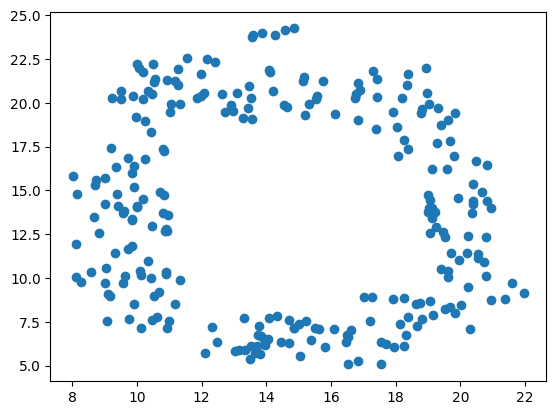

In [69]:
x_train.shape
i = np.random.randint(0, 60000)
plt.scatter(*x_train[i].T)
# plt.xlim(7., 23)
# plt.ylim(4., 25)

In [70]:
params, losses, accs = train(dataset, num_train_steps=N_STEPS)

evaluate(dataset, params)

fig, axs = plt.subplots(1, 2, dpi=200, figsize=(8.,4.))
ax = axs[0]
ax.semilogy(losses[::10])
ax = axs[1]
ax.plot(accs[::10])
plt.show()

n_plot = 8

net = hk.without_apply_rng(hk.transform(net_fn))

c, n = 0, 0
total_accuracy = 0.
for _ in range(len(dataset)):

    x = dataset[_]["input_graph"]
    label = dataset[_]["target"]

    y_ = net.apply(params, x)
    mask = jraph.get_graph_padding_mask(y_)

    accuracy = jnp.sum(     
        (jnp.argmax(y_.globals, axis=1) == label) * mask) / jnp.sum(mask)
    print(f"{jnp.argmax(y_.globals, axis=1)[0]} {int(dataset[_]['target'])}")

    total_accuracy += accuracy

    total_accuracy /= _
    print(f"ACCURACY = {total_accuracy:.2f}%")

    # Try rotating the graph to test invariance of classification
    print("TESTING ROTATION INVARIANCE.")
    key = jr.PRNGKey(1294)
    n_test = 10
    ix = jr.randint(key, shape=(n_test,), minval=0, maxval=n_test)
    dataset = get_rotated_mnist_graphs(
    X[ix], Y[ix], n_graphs=n_test, r_link=R_LINK, plot=True)

    for i in range(n_test):
        x, y = dataset[i]["input_graph"], dataset[i]["target"]
        x = pad_graph_to_value(x, PAD_VALUE)
        # label = jnp.concatenate([y, jnp.array([0])])
        label = hk.one_hot(label, 10)

        y_ = net.apply(params, x)
        mask = jraph.get_graph_padding_mask(y_) 

        # accuracy = jnp.sum(     
        #     (jnp.argmax(y_.globals, axis=1) == y) * mask) / jnp.sum(mask)

        # no mask, globals stay same size always?
        accuracy = jnp.sum(jnp.argmax(y_.globals, axis=1) == y) 
        print(f"{jnp.argmax(y_.globals, axis=1)[0]} {int(dataset[i]['target'])}")

n_params = 3.98E+05
step: 000000, loss: 1902.6865, acc: 0.0000
step: 000100, loss: 102.1514, acc: 0.0000
step: 000200, loss: 134.1304, acc: 0.0000
step: 000300, loss: 40.8889, acc: 0.0000
step: 000400, loss: 175.5214, acc: 0.0000
step: 000500, loss: 206.1655, acc: 0.0000
step: 000600, loss: 0.4960, acc: 100.0000
step: 000700, loss: 395.5026, acc: 0.0000
step: 000800, loss: 326.0222, acc: 0.0000
step: 000900, loss: 171.5998, acc: 0.0000
step: 001000, loss: 119.0565, acc: 0.0000
step: 001100, loss: 57.7773, acc: 0.0000
step: 001200, loss: 223.1553, acc: 0.0000
step: 001300, loss: 0.0000, acc: 100.0000
step: 001400, loss: 108.3051, acc: 0.0000
step: 001500, loss: 0.3343, acc: 100.0000
step: 001600, loss: 0.0842, acc: 100.0000
step: 001700, loss: 37.5105, acc: 0.0000
step: 001800, loss: 403.8441, acc: 0.0000
